# Making models with Bagpipes
### CAM-SUST Summer School on Astrophysics 2025
<div style="display: flex; justify-content: flex-start; gap: 20px;">
    <img src="https://image2url.com/images/1757362010448-841fc1b0-c536-4424-ae6a-623df7f8fea7.png" 
         alt="Bagpipes Image" style="width: 20%;">
    <img src="https://cam-sust.org/images/cam-white.png" 
         alt="CAM Image" style="width: 20%;">
</div>

##### Instructor: Tanmoy Bhowmik

References:
1. Woods, P. BAGPIPES. Nat Astron 8, 1205 (2024). https://doi.org/10.1038/s41550-024-02360-2
2. A C Carnall, R J McLure, J S Dunlop, R Davé, Inferring the star formation histories of massive quiescent galaxies with bagpipes: evidence for multiple quenching mechanisms, Monthly Notices of the Royal Astronomical Society, Volume 480, Issue 4, November 2018, Pages 4379–4401, https://doi.org/10.1093/mnras/sty2169



This notebook will show you how to make a model galaxy spectrum. The two main steps in this process are 
1. defining the physical parameters of the galaxy you would like to model, and 
2. defining the observables (spectroscopy and/or photometry) you would like to obtain predictions for.

You'll need to understand the syntax used here before moving on to fitting observational data. For further information see the [making model galaxies](http://bagpipes.readthedocs.io/en/latest/model_galaxies.html) page of the documentation.

## The model_components dictionary

Instructions about what kind of model to make are passed to the code via the [model components dictionary](https://bagpipes.readthedocs.io/en/latest/model_components.html). 

Each "component" is a sub-dictionary containing information about either the star-formation history, the dust model or the nebular emission model. 
A number of global properties can also be specified. The only required components are the observed redshift, and at least one star formation history component.

All of the physical parameters the user provides when creating a model_galaxy object are passed within the model_components dictionary. 

# Global parameters
All other parameter values must first be placed within component dictionaries, which are then inserted into model_components. Aside from observed redshift, the only other thing model_components must contain to be valid is at least one star-formation history component.

A simple tau model with Calzetti dust can be set up as follows.

In [31]:
import bagpipes as pipes
import numpy as np

# τ-model (exponential SFH).
exp = {}                          # τ-model star formation history component
exp["age"] = 3.                   # Gyr   # the e-folding timescale of star formation. Small τ → faster decline.
exp["tau"] = 0.75                 # Gyr
exp["massformed"] = 9.            # log_10(M*/M_solar)  # Means 10^9 M_O of stars have formed in total.
exp["metallicity"] = 0.5          # Z/Z_oldsolar   #half of the (old) solar metallicity used in Bagpipes.


# Dust attenuation ( Defines how starlight is dimmed and reddened by dust.)
dust = {}                         # Dust component
dust["type"] = "Calzetti"         # Define the shape of the attenuation curve
dust["Av"] = 0.2                  # total V-band attenuation (magnitudes)

# Combine into the model
model_components = {}                   # The model components dictionary
model_components["redshift"] = 1.0      # Observed redshift  #From observed redshift, the only other thing model_components must contain to be valid is at least one star-formation history component.
model_components["exponential"] = exp   
model_components["dust"] = dust

## Defining filter curves

If you would like to obtain predictions for photometric fluxes which would be observed for an object with the parameters listed above, you'll first need to define a list of filter curves, or filt_list, for the code to calculate photometric fluxes through.

A filt_list simply contains paths from the current working directory (or absolute paths) to the locations the filter curve files are stored. Filter curve files should start with a column of wavelengths in Angstroms, followed by a column of relative transmission values.

Through these examples we'll stick with the [CANDELS GOODS South catalogue](https://archive.stsci.edu/prepds/candels/) of Guo et al. (2013). The filters are as follows.

In [32]:
goodss_filt_list = ["VIMOS_U",
                    "f435w",
                    "f606w",
                    "f775w",
                    "f850lp",
                    "f098m",
                    "f105w",
                    "f125w",
                    "f160w",
                    "ISAAC_Ks",
                    "HAWKI_K",
                    "IRAC1",
                    "IRAC2",
                    "IRAC3",
                    "IRAC4"]

I usually find it more convenient to store these in a text file and load them up as an array:

In [33]:
goodss_filt_list = np.loadtxt("goodss_filt_list.txt", dtype="str")

## Making the model

We're now ready to make our model galaxy. 
Model spectrum generation

1. Bagpipes takes your model_components dictionary (SFH, dust, metallicity, redshift, etc.).
2. Builds a stellar population spectrum 
3. Apply redshift + IGM attenuation
4. Shifts the spectrum to 𝑧=1.0 (according to our define value).
5. Applies IGM absorption if relevant.
6. Convolve with filter curves

For each filter in goodss_filt_list, Bagpipes integrates the model spectrum through the filter transmission curve.
Produces synthetic photometry (fluxes in each band).

Output model object
model is a Bagpipes object that stores both the full model spectrum and the corresponding photometry.

In [34]:
model = pipes.model_galaxy(model_components, filt_list=goodss_filt_list)

We can generate a quick plot to see what the model spectrum and star-formation history look like with:

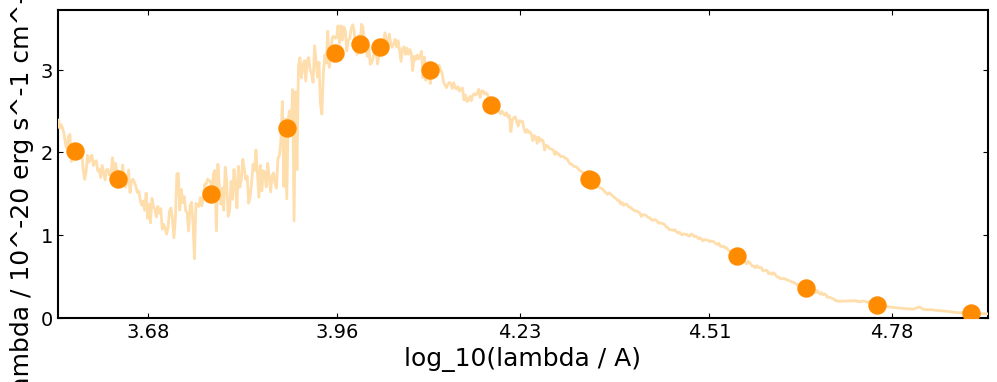

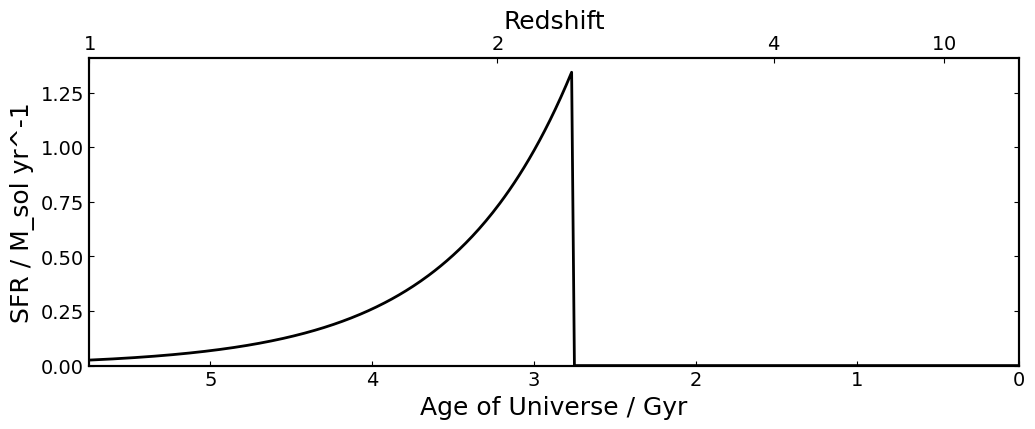

In [35]:
fig = model.plot()
fig = model.sfh.plot()

## Updating model parameters

The parameters of a model can be updated to change the output model observables. This  is computationally much faster than making a new model, and is achieved using the update method. We can change numerical values in model_components and pass it to the update method to change the model spectrum.

The update method does not support adding or removing components, e.g. adding nebular emission, or changing non-numerical values e.g. the type of dust.

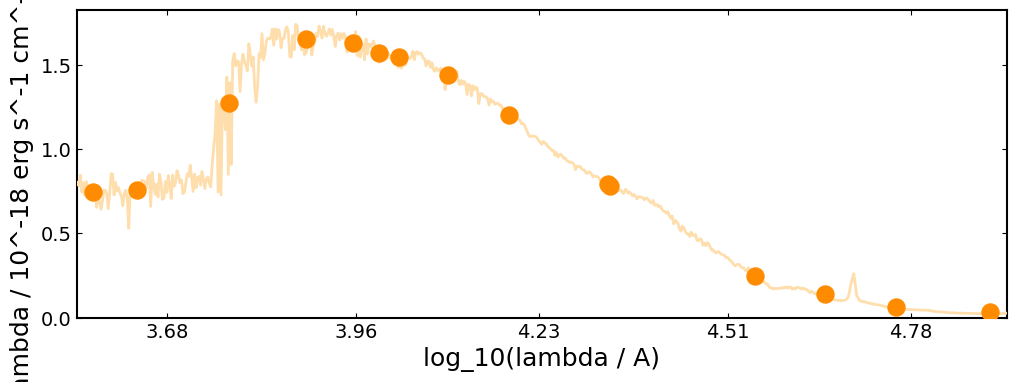

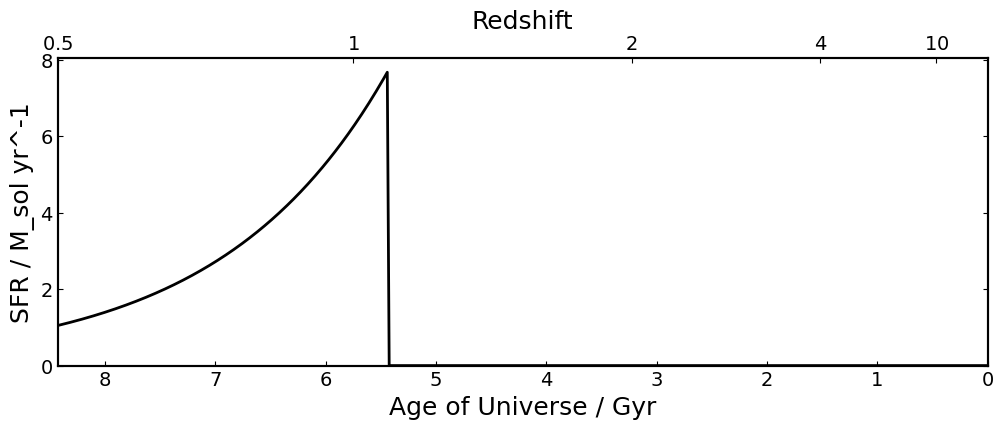

In [42]:
exp["massformed"] = 10.           
exp["tau"] = 1.5
dust["Av"] = 1.0
model_components["redshift"] = 0.5

model.update(model_components)
fig = model.plot()
fig = model.sfh.plot()

## Adding complexity to the model - nebular emission

Now we can make the model a little more interesting. Let's add nebular emission and velocity dispersion.

Note that because we're adding a new component we need to re-generate a new model rather than using the update method, which is only designed to update numerical parameter values.

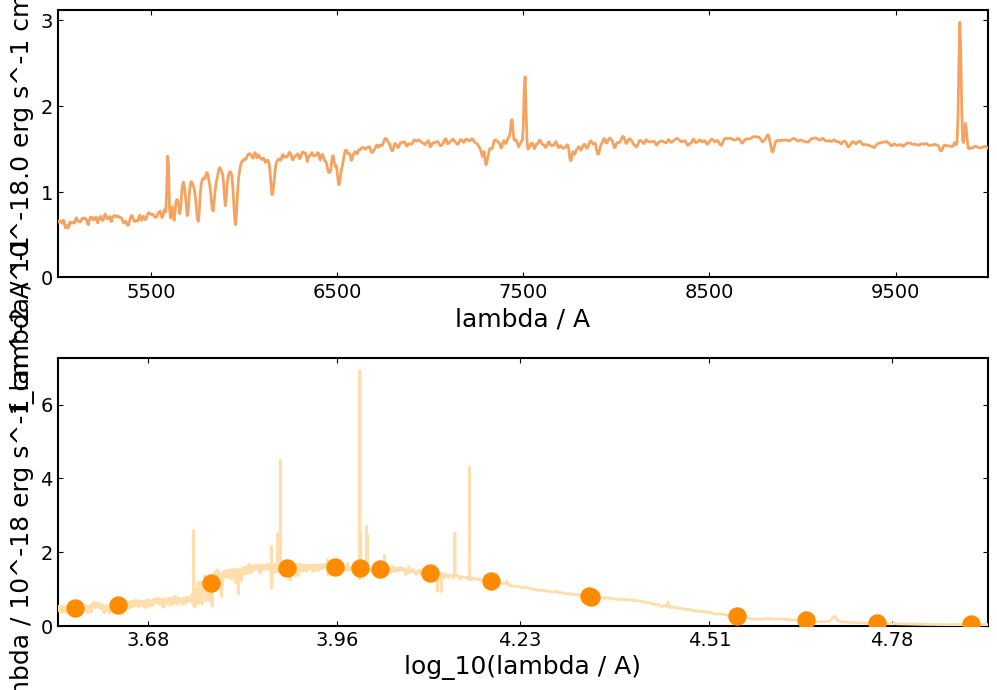

In [44]:
nebular = {}                      # Nebular emission component
nebular["logU"] = -3.             # log_10(ionization parameter)

dust["eta"] = 3.                  # Extra dust for young stars: multiplies Av

model_components["t_bc"] = 0.01         # Lifetime of birth clouds (Gyr)
model_components["veldisp"] = 200.      # km/s
model_components["nebular"] = nebular

model = pipes.model_galaxy(model_components, filt_list=goodss_filt_list, spec_wavs=np.arange(5000., 10000., 5.))

fig = model.plot()

## Adding complexity to the model - star-formation histories

Let's try out a more interesting star-formation history. We'll try a double-power-law and some bursts. Multiple components of the same type can be distinguished by numbering each component:

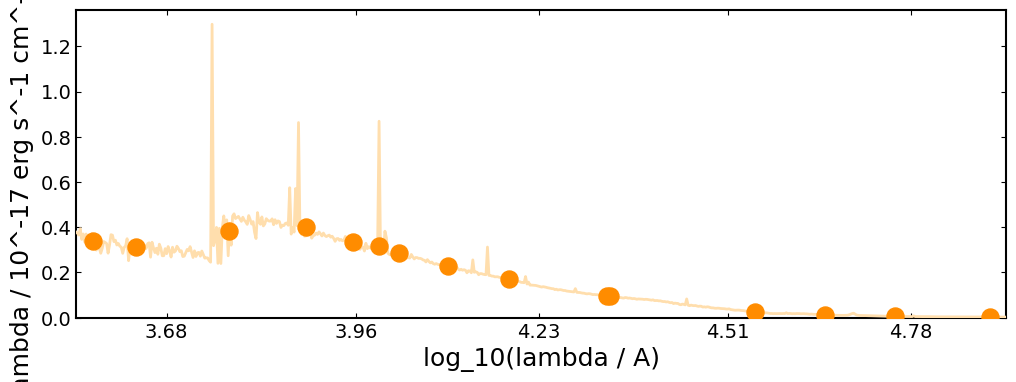

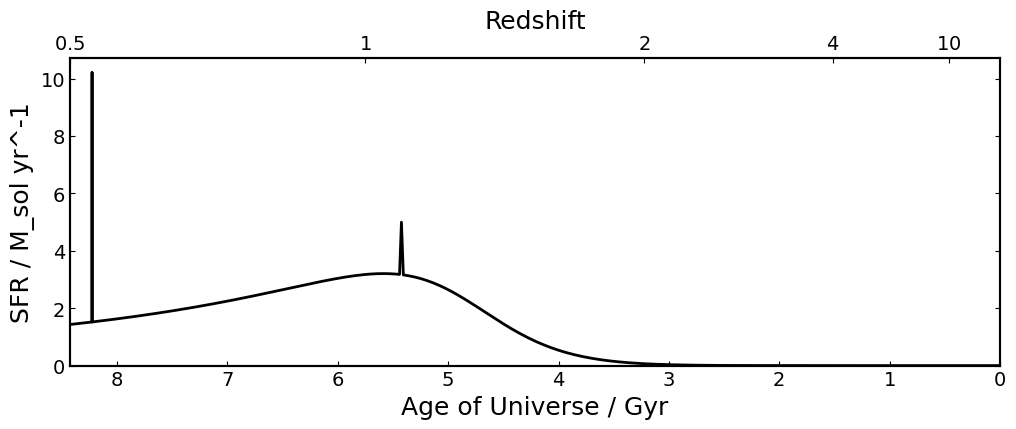

In [45]:
dust = {}                         
dust["type"] = "Calzetti"         
dust["Av"] = 0.2                  
dust["eta"] = 3.                  

# Nebular emission
nebular = {}                      
nebular["logU"] = -3.             

# Double power-law SFH
# Double power-law SFH is more flexible than an exponential. Alpha & beta → control the slope before and after the peak of star formation. tau → characteristic timescale.
dblplaw = {}
dblplaw["tau"] = 5.
dblplaw["alpha"] = 2.5
dblplaw["beta"] = 10.
dblplaw["massformed"] = 10.
dblplaw["metallicity"] = 0.5


#Two additional bursts
burst1 = {}
burst1["age"] = 0.2
burst1["massformed"] = 7.
burst1["metallicity"] = 1.

burst2 = {}
burst2["age"] = 3.
burst2["massformed"] = 7.5
burst2["metallicity"] = 0.2


# Combines everything into a single Bagpipes model dictionary.
model_components = {}                   
model_components["redshift"] = 0.5
model_components["t_bc"] = 0.01         
model_components["veldisp"] = 200. 
model_components["burst1"] = burst1
model_components["burst2"] = burst2
model_components["dblplaw"] = dblplaw
model_components["dust"] = dust
model_components["nebular"] = nebular

model = pipes.model_galaxy(model_components, filt_list=goodss_filt_list)

fig = model.plot()
sfh = model.sfh.plot()

Finally, let's try out a custom star-formation history. You can pass a numpy array containing a column of ages in years and a column of star-formation rates in Solar masses per year:

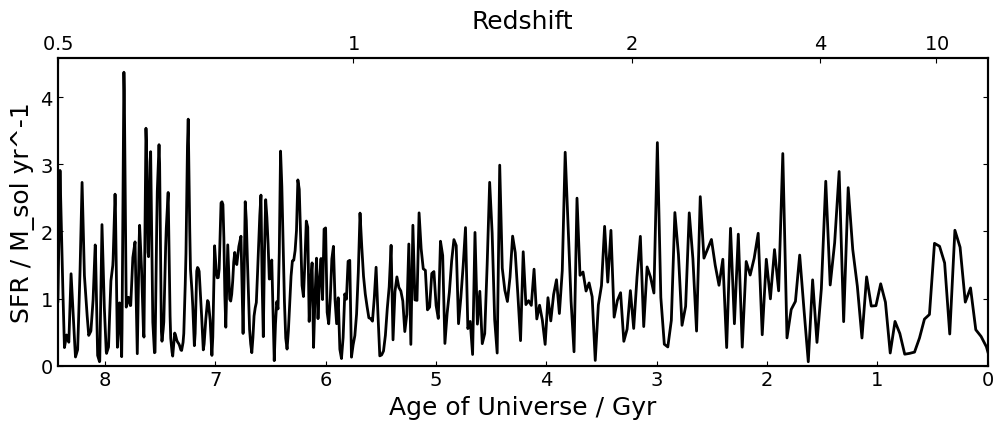

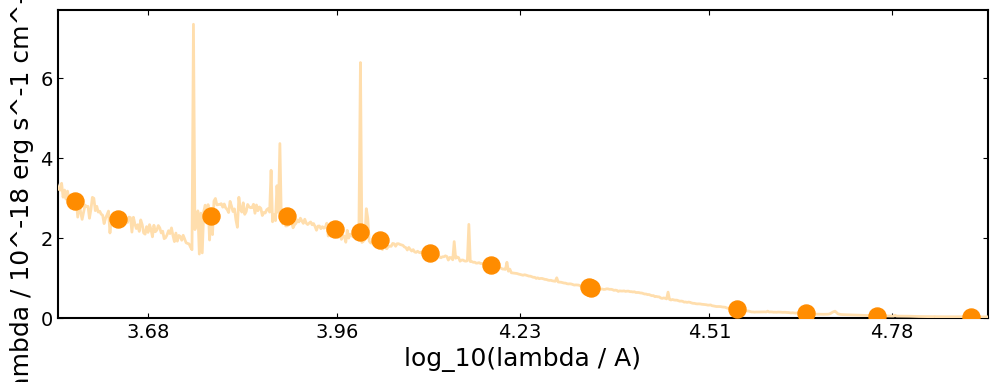

In [46]:
dust = {}                         
dust["type"] = "Calzetti"         
dust["Av"] = 0.2                  
dust["eta"] = 3.                  

nebular = {}                      
nebular["logU"] = -3.             


# For Custom Star Formation History
sfh = np.zeros((500, 2))
sfh[:, 0] = np.arange(0., 10., 0.02)*10**9
sfh[:, 1] = np.abs(np.random.randn(500))

# Warp into a custom components
custom = {}
custom["history"] = sfh
custom["massformed"] = 10.
custom["metallicity"] = 1.

model_components = {}                   
model_components["redshift"] = 0.5
model_components["t_bc"] = 0.01         
model_components["veldisp"] = 200. 
model_components["custom"] = custom
model_components["dust"] = dust
model_components["nebular"] = nebular

model = pipes.model_galaxy(model_components, filt_list=goodss_filt_list)

sfh = model.sfh.plot()
fig = model.plot()

## Plotting the full spectrum

As well as the spectroscopic or photometric observables requested from model_galaxy, the code retains an internal model for the spectrum over the full range of rest-frame wavelengths between 1 and 10^8 Angstroms. This model is stored in model_galaxy.spectrum_full, and the corresponding rest-frame wavelengths in model_galaxy.wavelengths. This full spectrum can be plotted with:

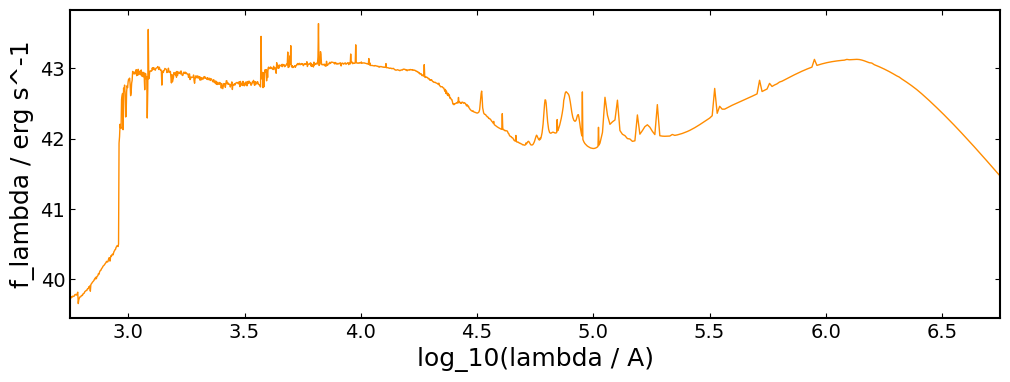

In [11]:
model.plot_full_spectrum()